# InfoGAN,CGAN and AC-GAN

Implementations based on original papers and the book : https://machinelearningmastery.com/generative_adversarial_networks

 https://arxiv.org/abs/1411.1784


## Install dependencies

In [1]:
!pip install pytorch-msssim
!pip install faiss-cpu
!pip install wandb
!pip install sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

## Import libraries

In [2]:
from torchvision import datasets, transforms

from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchsummary import summary
import torch.optim as optim
import logging

import wandb
import random

import  torch, time, os, pickle
import os
import torch
import numpy as np

from os import listdir


import torch
import torch.nn.functional as F

from pytorch_msssim import ssim  # For SSIM metric
import numpy as np
import torch.nn as nn
import torch.optim as optim


import matplotlib.image as mpimg



In [3]:
# Define device as cuda if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Save images to outputs folder

In [4]:
def save_images(epoch,y_,model_type):
    os.makedirs('outputs', exist_ok=True)
    z_ = torch.rand((batch_size, z_dim))
    y_vec_ = torch.zeros((batch_size, class_num)) \
            .scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
    fake_images = G(z_,y_vec_).detach().cpu()
    save_image(fake_images, f'outputs/'+model_type+str(epoch)+'.png', nrow=8, normalize=True)

## Define function to show generated images

In [5]:
def generated_images():
  folder_dir = "/content/outputs/"

  for image in os.listdir(folder_dir):
      img = mpimg.imread(folder_dir+image)
      plt.imshow(img)
      plt.axis('off')
      plt.show()

## Define Generator CGAN

In [37]:
class GeneratorCGAN(nn.Module):
    def __init__(self, nz=100, nc=1, input_size=32, class_num=10):
        super(GeneratorCGAN, self).__init__()
        self.nz = nz
        self.nc = nc
        self.input_size = input_size
        self.class_num = class_num


        self.fc = nn.Sequential(
            nn.Linear(self.nz + self.class_num, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.nc, 4, 2, 1),
            nn.Tanh(),
        )

        self.apply(self._initialize_weights)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)


        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))


        x = self.deconv(x)

        return x

    def _initialize_weights(self, m):
        if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


## Define Generator InfoGAN
Based in the proposed paper: https://arxiv.org/abs/1606.03657


In [17]:
class Generator(nn.Module):
    def __init__(self,nz=100, nc=1, input_size=32, class_num=10):
        super(Generator, self).__init__()
        self.nz = nz
        self.nc = nc
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.nz+ self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.nc, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x



In [6]:
# Define weights

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

## Define CGAN Discriminator

In [18]:
class Discriminator(nn.Module):
    def __init__(self, nz=1, nc=1, input_size=32, class_num=10):
        super(Discriminator, self).__init__()
        self.nz = nz
        self.nc = nc
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(self.nz + self.class_num, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.nc),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x



In [7]:
# Define hyperparameters

batch_size=64

input_size = 28

z_dim = 62

class_num = 10

sample_num = class_num ** 2


## Define Dataset

In [8]:
def data_set(batch_size):

    # Define transformations (convert to tensor + normalize)

    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

    dataloader = DataLoader(train_dataset,  batch_size)

    return dataloader


data_loader = data_set(batch_size)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.0MB/s]


## Define KID function

The following metrics are based on the following source: https://medium.com@heyamit10/pytorch-implementation-of-common-gan-metrics-86f993f6e737

Changes were made to the implementation of the methods in order to modify them for the dataset used in this work

In [9]:
def polynomial_mmd(x, y, degree=3, gamma=None, coef0=1):
    # Returns the polynomial MMD between x and y.

    # Reshape to 2D ensuring the same number of features
    x = x.view(x.size(0), -1)
    y = y.view(y.size(0), -1)

    # Check if feature dimensions match
    if x.shape[1] != y.shape[1]:
        raise ValueError(f"Feature dimensions do not match: x has {x.shape[1]} features, y has {y.shape[1]} features. Ensure real and generated images have the same number of channels.")

    if gamma is None:
        gamma = 1.0 / x.shape[1]
    kernel_xx = (gamma * x.mm(x.t()) + coef0) ** degree
    kernel_yy = (gamma * y.mm(y.t()) + coef0) ** degree
    kernel_xy = (gamma * x.mm(y.t()) + coef0) ** degree
    return kernel_xx.mean() + kernel_yy.mean() - 2 * kernel_xy.mean()



def kernel_inception_distance(real_features, generated_features):
    # Calculates the Kernel Inception Distance (KID) between real and generated features.

    # Ensure real and generated features have the same number of channels
    if real_features.shape[1] != generated_features.shape[1]:
         real_features = real_features[:, :generated_features.shape[1], :, :]


    # Calculate KID using polynomial MMD
    real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)
    return polynomial_mmd(real_features, generated_features)

In [10]:
def inicialization(sample_num,z_dim,class_num):
    sample_z_ = torch.zeros((sample_num, z_dim))

    # Create fixed latent vectors (same noise for each class)
    for i in range(class_num):
        sample_z_[i * class_num] = torch.rand(1, z_dim)
        for j in range(1, class_num):
            sample_z_[i * class_num + j] = sample_z_[i * class_num]

    # Create class labels for one-hot encoding
    temp = torch.zeros((class_num, 1))
    for i in range(class_num):
        temp[i, 0] = i

    # Repeat class labels to match the sample size
    temp_y = torch.zeros((sample_num, 1))
    for i in range(class_num):
        temp_y[i * class_num: (i + 1) * class_num] = temp

    # Convert labels to one-hot encoding
    sample_y_ = torch.zeros((sample_num, class_num)) \
        .scatter_(1, temp_y.type(torch.LongTensor), 1)

    return sample_z_, sample_y_


In [11]:
def label_processing(batch_size,z_dim,class_num,input_size,y_):

  # Sample random noise and prepare label vectors

        z_ = torch.rand((batch_size, z_dim))
        y_vec_ = torch.zeros((batch_size, class_num)) \
            .scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)

        y_fill_ = y_vec_.unsqueeze(2).unsqueeze(3) \
            .expand(batch_size, class_num, input_size, input_size)

        return z_,y_vec_,y_fill_


## Define function to plot losses

In [12]:
def plot_losses(d_losses, g_losses,gan_type):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses '+gan_type)
    plt.legend()
    plt.grid()
    os.makedirs('Metrics', exist_ok=True)
    plt.savefig('./Metrics/'+gan_type+'_generator_discriminator_losses.png')
    plt.show()

## Define function to plot SSIM Score

In [13]:
def ssim_plot(SSIM_SCORES_EPOCHS,gan_type):
    plt.title("SSIM for every Epoch")
    plt.plot(SSIM_SCORES_EPOCHS,color="green")
    plt.grid()
    os.makedirs('Metrics', exist_ok=True)
    plt.savefig('./Metrics/'+gan_type+'SSIM.png')
    plt.show()

## Define function to plot KID Score

In [14]:
def kid_plot(KID_SCORES_EPOCHS,gan_type):
  plt.title("KID in every Epoch")
  plt.plot(KID_SCORES_EPOCHS,color="yellow")
  plt.grid()
  plt.savefig('./Metrics/'+gan_type+'_KID_losses.png')
  plt.show()





##  CGAN training definition




In [15]:
def train_cgan(d_loss_total,g_loss_total,x_,y_fill_,z_,y_vec_,y_real_,y_fake_):

    ############################
        # (1) Update D network: )
        ###########################
        # Train with all-real batch

        optimizerD.zero_grad()

        output = D(x_, y_fill_)
        errD_real = BCE_loss(output, y_real_)

        G_ = G(z_, y_vec_)
        D_fake = D(G_, y_fill_)
        errD_fake  = BCE_loss(D_fake, y_fake_)

        D_loss = errD_real + errD_fake

        d_loss_total +=  errD_real.item() + errD_fake.item()

        D_loss.backward()
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        optimizerG.zero_grad()

        G_ = G(z_, y_vec_)
        output = D(G_, y_fill_)
        errG = BCE_loss(output, y_real_)

        errG.backward()
        optimizerG.step()

        g_loss_total += errG.item()

        # Calculate KID
        real_images = torch.cat([x_, y_fill_], 1)
        fake = G_

        return D_loss, errG, real_images, fake


## Main train definition

In [39]:
def train_model(model_type,G,D,version):

      # Start a new wandb run to track this script.
      run = wandb.init(

          # Set the wandb entity.
          entity="lorrayne-reis-silva-city-university-of-london",
          # Set the wandb project where this run will be logged.
          project=model_type+version,
          # Track hyperparameters and run metadata.
          config={
              "learning_rate_G": 0.000055,
              "learning_rate_D": 0.0002,
              "architecture": model_type+version,
              "dataset": "Fashion-MNIST",
              "epochs": 20,
          },
      )


      d_losses = []
      g_losses = []
      SSIM_SCORES = []
      KID_SCORES = []


      sample_z_, sample_y_ = inicialization(sample_num,z_dim,class_num)

      # Labels for real and fake samples
      y_real_, y_fake_ = torch.ones(batch_size, 1), torch.zeros(batch_size, 1)

      # Start training
      D.train()

      num_epochs=20

      for epoch in range(num_epochs):

          d_loss_total = 0.0
          g_loss_total = 0.0

          G.train()

          for iter, (x_, y_) in enumerate(data_loader):
              if iter == data_loader.dataset.__len__() // batch_size:
                  break


              z_,y_vec_,y_fill_ = label_processing(batch_size,z_dim,class_num,input_size,y_)
              x_ = x_.view(x_.size(0), 1, input_size, input_size)

              if model_type in ["CGAN","CGAN_complete","InfoGan-CGAN"]:
                D_loss, errG, real_images, fake = train_cgan(d_loss_total,g_loss_total,x_,y_fill_,z_,y_vec_,y_real_,y_fake_)

              elif model_type in ["ACGAN","InfoGAN-ACGAN","CGAN_ACGAN"]:
                D_loss, errG, real_images, fake = train_acgan(D, G, d_loss_total, g_loss_total, y_real_, y_fake_, y_vec_, x_, z_, y_fill_)


              # Calculate KID
              kid = kernel_inception_distance(real_images.detach().cpu(), fake.detach().cpu())


              # Calculate SSIM
              score = ssim(x_, fake.detach())


              # Logging
              if (iter + 1) % 100 == 0:

                d_losses.append(D_loss.item())
                g_losses.append(errG.item())
                run.log({"D_loss": D_loss.item(), "G_loss": errG.item()})
                KID_SCORES.append(kid.item())
                SSIM_SCORES.append(score.detach().cpu())


                print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" % (
                      epoch + 1, iter + 1,
                      data_loader.dataset.__len__() // batch_size,
                      D_loss.item(), errG.item()
                  ))


          if (epoch+1) in [1,10,15,20]:
                    save_images(epoch+1,y_,model_type)


          os.makedirs('Epochs', exist_ok=True)
          torch.save(G.state_dict(), f'./Epochs/G_epoch_'+model_type+'_'+str(epoch)+'.pth')
          torch.save(D.state_dict(), f'./Epochs/D_epoch_'+model_type+'_'+str(epoch)+'.pth')



      return d_losses , g_losses , SSIM_SCORES,KID_SCORES
      run.finish()

## CGAN complete implementation

In [76]:
# Learning rates

lrG= 0.0003
lrD=0.0002
beta1=0.5
beta2=0.99

# Define model
G = GeneratorCGAN(nz=z_dim, nc=1, input_size=input_size, class_num=class_num)
D = Discriminator(nz=1, nc=1, input_size=input_size, class_num=class_num)

print(G)
print(D)

#Optimizers
optimizerG = optim.Adam(G.parameters(), lr=lrG, betas=(beta1, beta2))
optimizerD = optim.Adam(D.parameters(), lr=lrD, betas=(beta1, beta2))

# Define loss
BCE_loss = nn.BCELoss()

GeneratorCGAN(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=6272, bias=True)
    (3): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)

In [77]:
d_losses_cgan_complete ,g_losses_cgan_complete , SSIM_SCORES_cgan_complete ,KID_SCORES_cgan_complete = train_model("CGAN_complete",G,D,"35")

<ipython-input-14-fb27998ef762>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)


Epoch: [ 1] [ 100/ 937] D_loss: 0.33184254, G_loss: 2.02006578
Epoch: [ 1] [ 200/ 937] D_loss: 0.20489958, G_loss: 2.54285407
Epoch: [ 1] [ 300/ 937] D_loss: 0.06250378, G_loss: 3.56245327
Epoch: [ 1] [ 400/ 937] D_loss: 2.00522208, G_loss: 2.81461644
Epoch: [ 1] [ 500/ 937] D_loss: 1.06450558, G_loss: 1.07933676
Epoch: [ 1] [ 600/ 937] D_loss: 1.11600423, G_loss: 1.16975021
Epoch: [ 1] [ 700/ 937] D_loss: 0.96409905, G_loss: 1.10495341
Epoch: [ 1] [ 800/ 937] D_loss: 0.89229310, G_loss: 1.25979877
Epoch: [ 1] [ 900/ 937] D_loss: 0.88732266, G_loss: 1.26128519
Epoch: [ 2] [ 100/ 937] D_loss: 0.97825432, G_loss: 1.26041257
Epoch: [ 2] [ 200/ 937] D_loss: 1.02982247, G_loss: 1.26797080
Epoch: [ 2] [ 300/ 937] D_loss: 1.06599343, G_loss: 1.50359869
Epoch: [ 2] [ 400/ 937] D_loss: 0.91676682, G_loss: 1.30086172
Epoch: [ 2] [ 500/ 937] D_loss: 1.01732564, G_loss: 1.46706879
Epoch: [ 2] [ 600/ 937] D_loss: 0.77297115, G_loss: 1.42732036
Epoch: [ 2] [ 700/ 937] D_loss: 1.02139902, G_loss: 1.3

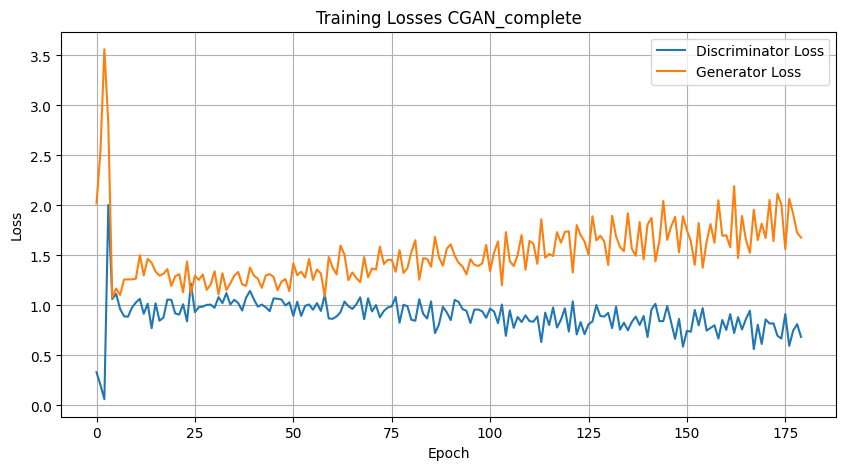

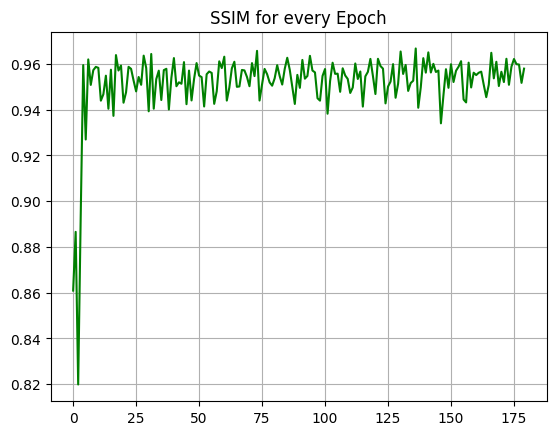

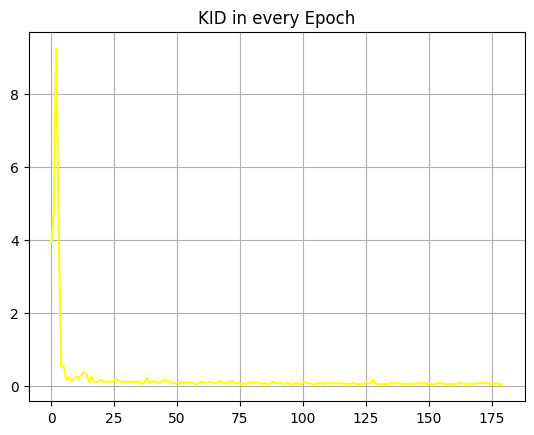

In [78]:
plot_losses(d_losses_cgan_complete, g_losses_cgan_complete,"CGAN_complete")
ssim_plot(SSIM_SCORES_cgan_complete,"CGAN_complete")
kid_plot(KID_SCORES_cgan_complete,"CGAN_complete")

#InfoGAN-CGAN

In [29]:
# Learning rates

lrG= 0.000055
lrD=0.0002
beta1=0.5
beta2=0.99

# Define model
G = Generator(nz=z_dim, nc=1, input_size=input_size, class_num=class_num)
D = Discriminator(nz=1, nc=1, input_size=input_size, class_num=class_num)

print(G)
print(D)

#Optimizers
optimizerG = optim.Adam(G.parameters(), lr=lrG, betas=(beta1, beta2))
optimizerD = optim.Adam(D.parameters(), lr=lrD, betas=(beta1, beta2))

# Define loss
BCE_loss = nn.BCELoss()

Generator(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [23]:
d_losses_infogan_cgan ,g_losses_infogan_cgan  , SSIM_SCORES_infogan_cgan ,KID_SCORES_infogan_cgan = train_model("InfoGan-CGAN",G,D,"20")

<ipython-input-9-fb27998ef762>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)


Epoch: [ 1] [ 100/ 937] D_loss: 0.65824282, G_loss: 1.51426387
Epoch: [ 1] [ 200/ 937] D_loss: 0.68137604, G_loss: 1.45170820
Epoch: [ 1] [ 300/ 937] D_loss: 0.99583519, G_loss: 1.18480957
Epoch: [ 1] [ 400/ 937] D_loss: 0.91767281, G_loss: 1.48294258
Epoch: [ 1] [ 500/ 937] D_loss: 1.09116483, G_loss: 0.99175644
Epoch: [ 1] [ 600/ 937] D_loss: 0.96502888, G_loss: 1.38049412
Epoch: [ 1] [ 700/ 937] D_loss: 0.96337676, G_loss: 1.24206388
Epoch: [ 1] [ 800/ 937] D_loss: 0.96633399, G_loss: 1.13873434
Epoch: [ 1] [ 900/ 937] D_loss: 0.85003281, G_loss: 1.29795194
Epoch: [ 2] [ 100/ 937] D_loss: 1.00061119, G_loss: 1.02252531
Epoch: [ 2] [ 200/ 937] D_loss: 0.90378779, G_loss: 1.14004707
Epoch: [ 2] [ 300/ 937] D_loss: 0.91515428, G_loss: 1.52539968
Epoch: [ 2] [ 400/ 937] D_loss: 0.91121268, G_loss: 1.41825891
Epoch: [ 2] [ 500/ 937] D_loss: 0.87066305, G_loss: 1.24018741
Epoch: [ 2] [ 600/ 937] D_loss: 0.87795973, G_loss: 1.55192673
Epoch: [ 2] [ 700/ 937] D_loss: 0.84205902, G_loss: 1.3

## Metrics Evaluation InfoGAN-CGAN

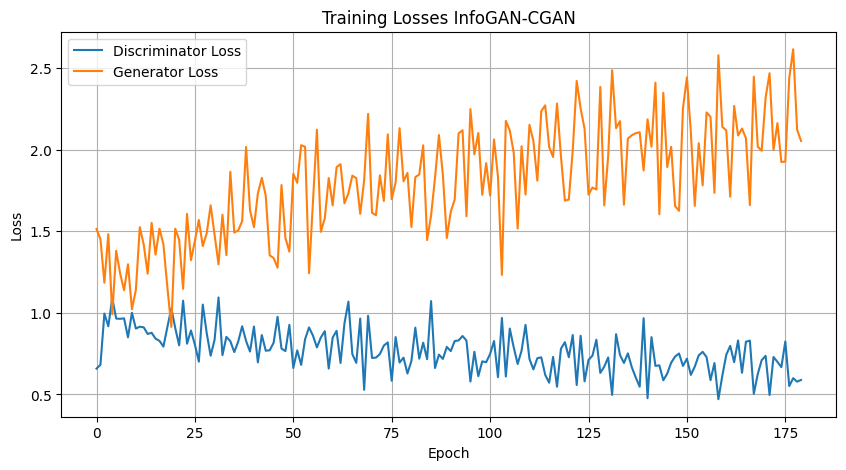

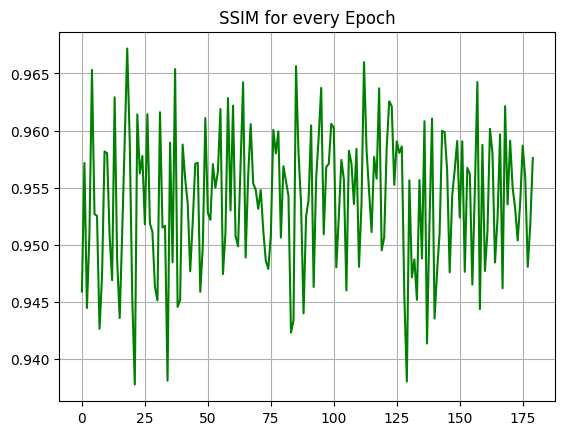

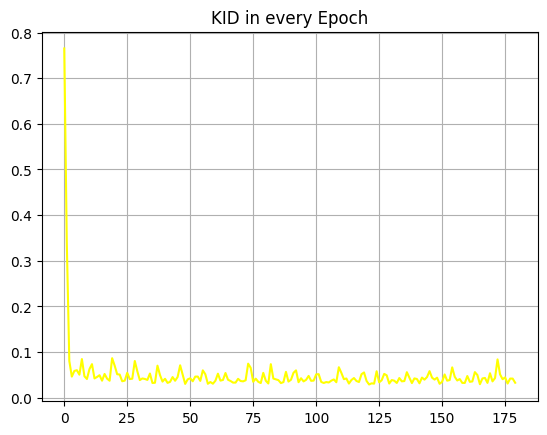

In [24]:
plot_losses(d_losses_infogan_cgan, g_losses_infogan_cgan,"InfoGAN-CGAN")
ssim_plot(SSIM_SCORES_infogan_cgan,"InfoGAN-CGAN")
kid_plot(KID_SCORES_infogan_cgan,"InfoGAN-CGAN")

# InfoGAN - ACGAN
Based in the proposed paper : https://arxiv.org/abs/1610.09585


In [30]:

class DiscriminatorACGAN(nn.Module):

    def __init__(self, nz=1, nc=1, input_size=32, class_num=10):
        super(DiscriminatorACGAN, self).__init__()
        self.nz = nz
        self.nc = nc
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(self.nz, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )
        self.dc = nn.Sequential(
            nn.Linear(1024, self.nc),
            nn.Sigmoid(),
        )
        self.cl = nn.Sequential(
            nn.Linear(1024, self.class_num),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc1(x)
        d = self.dc(x)
        c = self.cl(x)

        return d, c

In [31]:
# networks init ACGAN

input_size = 28
z_dim = 62
class_num = 10
sample_num = class_num ** 2
batch_size = 64

# networks init
lrG= 0.0002
lrD=0.0002
beta1=0.5
beta2=0.99

G = Generator(nz=z_dim, nc=1, input_size=input_size, class_num=class_num)
D = DiscriminatorACGAN(nz=1, nc=1, input_size=input_size, class_num=class_num)

print(G)
print(D)

optimizerG = optim.Adam(G.parameters(), lr=lrG, betas=(beta1, beta2))
optimizerD = optim.Adam(D.parameters(), lr=lrD, betas=(beta1, beta2))

# Define loss

BCE_loss = nn.BCELoss()
CE_loss = nn.CrossEntropyLoss()

Generator(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
DiscriminatorACGAN(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [33]:
def train_acgan(D,G,d_loss_total,g_loss_total,y_real_,y_fake_,y_vec_,x_,z_,y_fill_):

        ############################
        # (1) Update D network: )
        ###########################
        # Train with all-real batch

        optimizerD.zero_grad()

        # Real images
        D_real, C_real = D(x_)
        D_real_loss = BCE_loss(D_real, y_real_)
        C_real_loss = CE_loss(C_real, torch.max(y_vec_, 1)[1])

        # Fake images
        G_ = G(z_, y_vec_)
        D_fake, C_fake = D(G_)
        D_fake_loss = BCE_loss(D_fake, y_fake_)
        C_fake_loss = CE_loss(C_fake, torch.max(y_vec_, 1)[1])

        # Discriminator total loss

        D_loss = D_real_loss + C_real_loss + D_fake_loss + C_fake_loss
        D_loss.backward()
        optimizerD.step()

        d_loss_total += D_loss.item()


        # Update Generator network
        optimizerG.zero_grad()

        # Fake images a
        G_ = G(z_, y_vec_)
        D_fake, C_fake = D(G_)

        # Generator Loss
        G_loss = BCE_loss(D_fake, y_real_)
        C_fake_loss = CE_loss(C_fake, torch.max(y_vec_, 1)[1])

        # Total loss for Generator
        G_loss += C_fake_loss
        G_loss.backward()
        optimizerG.step()

        g_loss_total += G_loss.item()


        # Calculate real images for KID
        real_images = torch.cat([x_, y_fill_], 1)  # Concatenate x_ and y_fill_
        fake = G_

        return D_loss, G_loss, real_images, fake

In [34]:
d_losses_infogan_acgan,g_losses_infogan_acgan , SSIM_SCORES_infogan_acgan, KID_SCORES_infogan_acgan = train_model("InfoGAN-ACGAN",G,D,"10")

D_loss,▃▃█▇▆▆▅▄▅▆▄▅▄▅▅▄▇▄▄▂▄▂▃▅▃▄▄▂▄▄▂▃▃▂▁▄▃▄▁▂
G_loss,▂▁▂▃▃▄▅▄▄▃▂▄▅▅▇▄▄▆▃▅▇▅▂▇▆▇▇▆▇▄▆█▅█▇▆▆█▇▆
D_loss,0.58865
G_loss,2.05392


<ipython-input-9-fb27998ef762>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)


Epoch: [ 1] [ 100/ 937] D_loss: 1.51269543, G_loss: 0.97180927
Epoch: [ 1] [ 200/ 937] D_loss: 1.57661891, G_loss: 0.99818408
Epoch: [ 1] [ 300/ 937] D_loss: 1.53374159, G_loss: 1.02616847
Epoch: [ 1] [ 400/ 937] D_loss: 1.65308511, G_loss: 0.99611235
Epoch: [ 1] [ 500/ 937] D_loss: 1.37235594, G_loss: 0.96097457
Epoch: [ 1] [ 600/ 937] D_loss: 1.36594701, G_loss: 0.96994454
Epoch: [ 1] [ 700/ 937] D_loss: 1.77941322, G_loss: 0.89947808
Epoch: [ 1] [ 800/ 937] D_loss: 1.53581703, G_loss: 0.99434084
Epoch: [ 1] [ 900/ 937] D_loss: 1.33682024, G_loss: 0.99260163
Epoch: [ 2] [ 100/ 937] D_loss: 1.55271411, G_loss: 0.94811630
Epoch: [ 2] [ 200/ 937] D_loss: 1.65204573, G_loss: 0.96265024
Epoch: [ 2] [ 300/ 937] D_loss: 1.52379048, G_loss: 0.90761220
Epoch: [ 2] [ 400/ 937] D_loss: 1.53073537, G_loss: 0.95592952
Epoch: [ 2] [ 500/ 937] D_loss: 1.49256754, G_loss: 0.88127291
Epoch: [ 2] [ 600/ 937] D_loss: 1.33315110, G_loss: 0.95604557
Epoch: [ 2] [ 700/ 937] D_loss: 1.60360301, G_loss: 0.9

## Metrics Evalauation Info-ACGAN

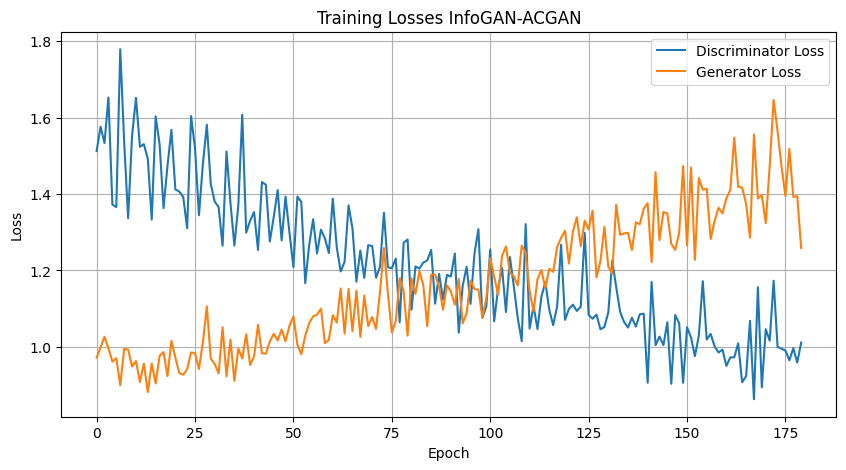

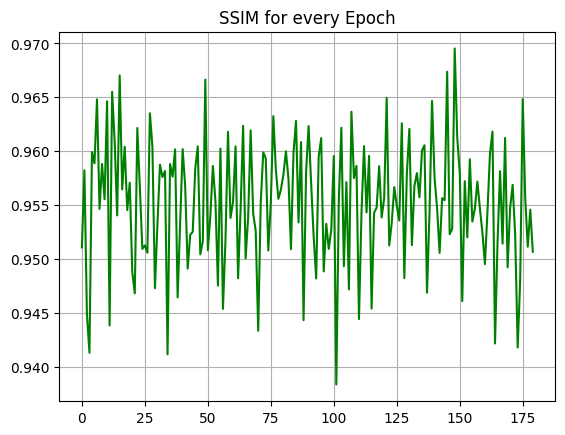

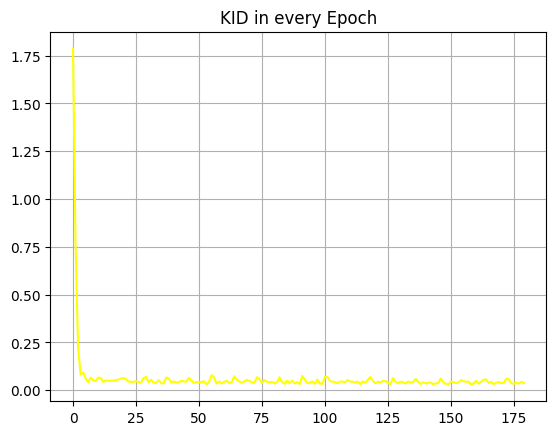

In [35]:
plot_losses(d_losses_infogan_acgan, g_losses_infogan_acgan,"InfoGAN-ACGAN")
ssim_plot(SSIM_SCORES_infogan_acgan,"InfoGAN-ACGAN")
kid_plot(KID_SCORES_infogan_acgan,"InfoGAN-ACGAN")

#CGAN - ACGAN

In [52]:
# networks init CGAN-ACGAN

input_size = 28
z_dim = 62
class_num = 10
sample_num = class_num ** 2
batch_size = 64

# networks init
lrG= 0.001
lrD=0.0002
beta1=0.5
beta2=0.99

G = GeneratorCGAN(nz=z_dim, nc=1, input_size=input_size, class_num=class_num)
D = DiscriminatorACGAN(nz=1, nc=1, input_size=input_size, class_num=class_num)

print(G)
print(D)

optimizerG = optim.Adam(G.parameters(), lr=lrG, betas=(beta1, beta2))
optimizerD = optim.Adam(D.parameters(), lr=lrD, betas=(beta1, beta2))

# Define loss

BCE_loss = nn.BCELoss()
CE_loss = nn.CrossEntropyLoss()

GeneratorCGAN(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=6272, bias=True)
    (3): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Tanh()
  )
)
DiscriminatorACGAN(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (fc1): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope

In [53]:
d_losses_cgan_acgan ,g_losses_cgan_acgan , SSIM_SCORES_cgan_acgan ,KID_SCORES_cgan_acgan = train_model("CGAN_ACGAN",G,D,"36")

D_loss,█▁
G_loss,▁█
D_loss,1.38087
G_loss,1.3036


<ipython-input-9-fb27998ef762>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)


Epoch: [ 1] [ 100/ 937] D_loss: 1.78101635, G_loss: 0.92322344
Epoch: [ 1] [ 200/ 937] D_loss: 1.74315631, G_loss: 1.03638041
Epoch: [ 1] [ 300/ 937] D_loss: 1.41243219, G_loss: 1.02875578
Epoch: [ 1] [ 400/ 937] D_loss: 1.60631335, G_loss: 1.13234270
Epoch: [ 1] [ 500/ 937] D_loss: 1.35063076, G_loss: 1.07690501
Epoch: [ 1] [ 600/ 937] D_loss: 1.37052429, G_loss: 1.04379416
Epoch: [ 1] [ 700/ 937] D_loss: 1.76586413, G_loss: 1.12910199
Epoch: [ 1] [ 800/ 937] D_loss: 1.44299865, G_loss: 1.13560045
Epoch: [ 1] [ 900/ 937] D_loss: 1.32465839, G_loss: 1.05441117
Epoch: [ 2] [ 100/ 937] D_loss: 1.63316429, G_loss: 1.17548633
Epoch: [ 2] [ 200/ 937] D_loss: 1.61471283, G_loss: 1.01930308
Epoch: [ 2] [ 300/ 937] D_loss: 1.59981072, G_loss: 1.11564875
Epoch: [ 2] [ 400/ 937] D_loss: 1.60126638, G_loss: 0.97686666
Epoch: [ 2] [ 500/ 937] D_loss: 1.37332678, G_loss: 1.00546789
Epoch: [ 2] [ 600/ 937] D_loss: 1.41382825, G_loss: 1.10419607
Epoch: [ 2] [ 700/ 937] D_loss: 1.71863008, G_loss: 1.0

## Metrics Evalauation CGAN-ACGAN

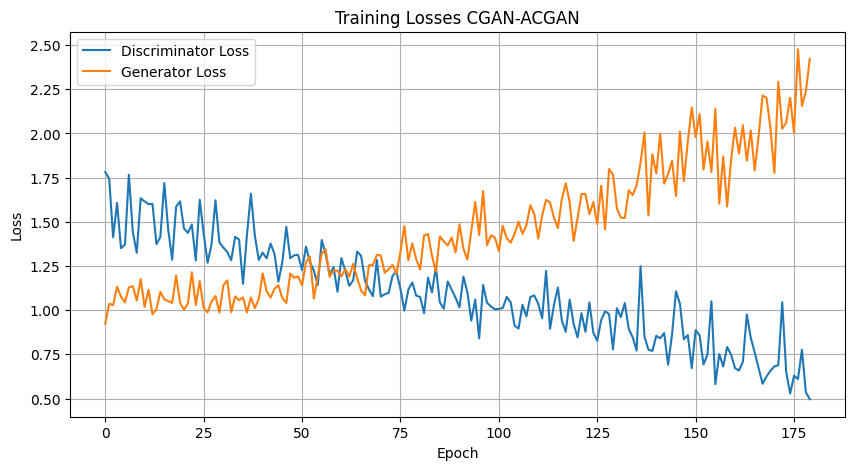

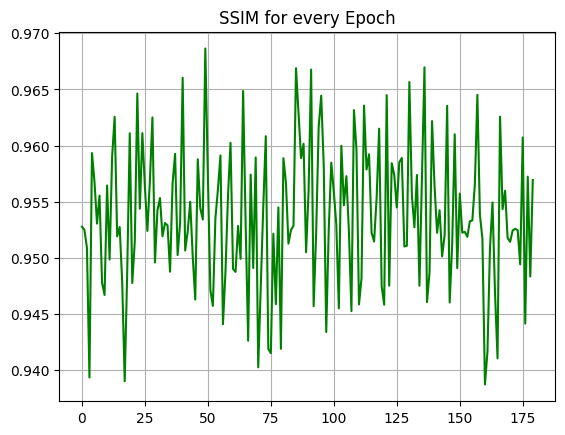

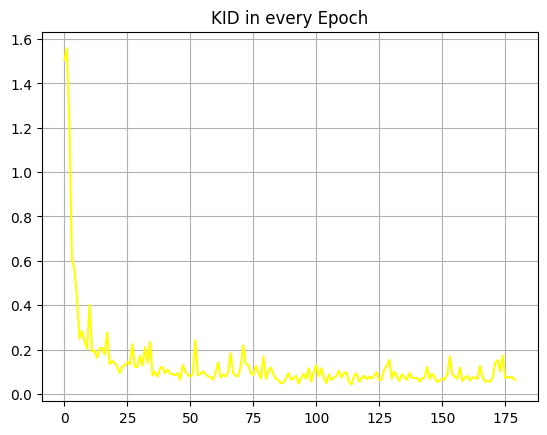

In [54]:
plot_losses(d_losses_cgan_acgan, g_losses_cgan_acgan,"CGAN-ACGAN")
ssim_plot(SSIM_SCORES_cgan_acgan,"CGAN-ACGAN")
kid_plot(KID_SCORES_cgan_acgan,"CGAN-ACGAN")